<img src="../images/UBC_MDS_logo.PNG" width="130" height="130" align="right"/>

# Lecture 3 - GLMs: Multinomial and Ordinal Logistic Regressions
### DSCI 562 - Regression II

Alexi Rodríguez-Arelis, **January 2021**

<h1>Outline<br><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Learning-Goals" data-toc-modified-id="1.-Learning-Goals-1">1. Learning Goals </a></span></li><li><span><a href="#2.-Categorical-Type-Responses" data-toc-modified-id="2.-Categorical-Type-Responses-2">2. Categorical Type Responses </a></span></li><li><span><a href="#3.-Multinomial-Logistic-Regression" data-toc-modified-id="3.-Multinomial-Logistic-Regression-3">3. Multinomial Logistic Regression </a></span></li><li><span><a href="#4.-Ordinal-Logistic-Regression" data-toc-modified-id="4.-Ordinal-Logistic-Regression-4">4. Ordinal Logistic Regression </a></span></li></ul></div>

In [2]:
source("../scripts/support_functions.R")
suppressPackageStartupMessages(library(VGAM))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(MASS))
suppressPackageStartupMessages(library(scales))
library(foreign)

## 1. Learning Goals

By the end of this lecture, we will be able to:

- Extend the link function concept of the generalized linear models (GLMs) to other discrete categorical responses.
- Outline the modelling framework of the multinomial logistic regression.
- Fit and interpret the multinomial logistic regression.
- Use the multinomial logistic regression for prediction.

- Outline the modelling framework of the ordinal logistic regression.
- Explain the concept of *proportional odds*.
- Fit and interpret ordinal logistic regression.
- Use the ordinal logistic regression for prediction.

## 2. Categorical Type Responses

So far, we have dealt with continuous, binary, and count responses using classical, binomial logistic, and Poisson (or quasi-Poisson or negative binomial) regressions respectively.

Nonetheless, we have not covered those discrete responses with more than two categories. Recall that the nature of these responses could be:

- **Nominal.** We have categories that do not follow any specific order—for example, the type of dwelling according to the Canadian census: *single-detached house*, *semi-detached house*, *row house*, *apartment*, and *mobile home*.
- **Ordinal.** The categories, in this case, follow a specific order—for example, the Likert scale of survey items: *strongly disagree*, *disagree*, *neutral*, *agree*, and *strongly agree*.

Moreover, we have seen that using least-squares to fit a model with a categorical response variable has some problems:

- Frequently the restricted range is not respected.

- Then, we used generalized linear models (GLMs) to fit a binomial logistic regression in [**Lecture 2**](lecture2_glm_binomial_logistic_and_count_regression.ipynb).

- However, binomial logistic regression only works with two classes: *success* or *failure*.
- What if we have more than two classes in the categorical response?

## 3. Multinomial Logistic Regression

Assuming we have a random sample of $n$ elements, recall that the $i$th response (for $i = 1, \dots, n$) in a binomial logistic regression is 

\begin{equation*}
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if it is a success},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
\end{equation*}

Therefore

\begin{equation*}
Y_i \sim \text{Bernoulli}(\pi_i),
\end{equation*}

whose probability of success is $\pi_i$.

Moreover, the term "binomial" arises from the fact that a sequence of $n$ *independent* Bernoulli trials is a Binomial distribution.

### 3.1. General Modelling Framework of the Multinomial Logistic Regression

Recall that in [**Lecture 2**](lecture2_glm_binomial_logistic_and_count_regression.ipynb) we used 

\begin{align*}
\eta_i = \mbox{logit}(\pi_i)= \log\left(\frac{\pi_i}{1 - \pi_i}\right) &= \log\left[\frac{\Pr(Y_i = 1\mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i = 0 \mid X_{i,1}, \ldots, X_{i,p})}\right] \nonumber \\
&= \beta_0 + \beta_1 X_{i, 1} + \beta_1 X_{i, 2} + \ldots + \beta_p X_{i, p}.
\end{align*}

In plain words, the **natural logarithm** of the odds between success and failure is equal to a linear predictor of $p$ regressors $X_{i, 1}, X_{i, 2}, \dots , X_{i, p}$ on the right-hand side.

Nonetheless, what if the response is **nominal** and has more than two categories?

In that case, let us suppose that a given *discrete* nominal response $Y_i$ has categories $1, 2, \dots, k$.

> **Note:** The categories $1, 2, \dots, k$ **are merely labels here**. Thus, they do not implicate an ordinal scale.

Now, we will have a *multinomial distribution* where $\pi_{i,1}, \pi_{i,2}, \dots, \pi_{i,k}$ are the probabilities that $Y_i$ will belong to categories $1, 2, \dots, k$ respectively; i.e.,

\begin{equation*}
\Pr(Y_i = 1) = \pi_{i,1} \;\;\;\; \Pr(Y_i = 2) = \pi_{i,2} \;\; \dots \;\; \Pr(Y_i = k) = \pi_{i,k},
\end{equation*}

where

\begin{equation*}
\sum_{j = 1}^k \pi_{i,j} = \pi_{i,1} + \pi_{i,2} + \dots + \pi_{i,k} = 1.
\end{equation*}

A particular highlight is that the binomial distribution is the special multinomial case when $k = 2$.

The multinomial regression model is similar to the binomial logistic regression model in the sense that we are also modelling the logarithm of the odds.

However, only one logarithm of the odds (or *logit*) will not be enough anymore. We can capture the odds between two categories with a single *logit* function. What about adding some other ones?  

Here is what we can do:

1. Pick one of the categories to be the *baseline*. For example, the category "$1$".
2. For each of the **other** categories, we model the logarithm of the odds to the baseline category.

### Optional Material

We end up with a system of $k - 1$ link functions in the multinomial regression model as follows:

\begin{gather*}
\eta_i^{(2,1)} = \log\left[\frac{\Pr(Y_i = 2\mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,p})}\right] = \beta_0^{(2,1)} + \beta_1^{(2,1)} X_{i, 1} + \beta_2^{(2,1)} X_{i, 2} + \ldots + \beta_p^{(2,1)} X_{i, p} \\
\eta_i^{(3,1)} = \log\left[\frac{\Pr(Y_i = 3\mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,p})}\right] = \beta_0^{(3,1)} + \beta_1^{(3,1)} X_{i, 1} + \beta_2^{(3,1)} X_{i, 2} + \ldots + \beta_p^{(3,1)} X_{i, p} \\
\vdots \\
\eta_i^{(k,1)} = \log\left[\frac{\Pr(Y_i = k\mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,p})}\right] = \beta_0^{(k,1)} + \beta_1^{(k,1)} X_{i, 1} + \beta_2^{(k,1)} X_{i, 2} + \ldots + \beta_p^{(k,1)} X_{i, p}.
\end{gather*}

Note that the superscript $(m, 1)$ indicates that the equation is on level $m$ (for $m = 2, \dots, k$) with respect to level $1$. Furthermore, **the regression coefficients are different for each link function**.

With some algebraic manipulation, we can show that the probabilities $\pi_{i,1}, \pi_{i,2}, \dots, \pi_{i,k}$ of $Y_i$ belonging to categories $1, 2, \dots, k$ are:

\begin{gather*}
\pi_{i,1} = \Pr(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,p}) = \frac{1}{1 + \sum_{j = 2}^k \exp \big( \eta_i^{(j,1)} \big)} \\
\pi_{i,2} = \Pr(Y_i = 2 \mid X_{i,1}, \ldots, X_{i,p}) = \frac{\exp \big( \eta_i^{(2,1)} \big)}{1 + \sum_{j = 2}^k \exp \big( \eta_i^{(j,1)} \big)} \\
\vdots \\
\pi_{i,k} = \Pr(Y_i = k \mid X_{i,1}, \ldots, X_{i,p}) = \frac{\exp \big( \eta_i^{(k,1)} \big)}{1 + \sum_{j = 2}^k \exp \big( \eta_i^{(j,1)} \big)}.
\end{gather*}

If we sum all $k$ probabilities above, the sum will be equal to $1$. **This is particularly important when we want to use this model for making predictions in classification matters**.

### 3.2. New Zealand Marital Dataset

The data frame `marital.nz` is included in the `VGAM` package. We are going to fit a multinomial logistic regression using this dataset.

> The data was collected in the early 1990s. It contains 6053 observations and is part of a self-administered questionnaire to a large New Zealand workforce, conducted between 1992 and 1993.

Firstly, we will load the data and select the following variables:

- `mstatus`: the marital status of the respondent, a discrete and nominal response of four categories (`Divorced/Separated`, `Married/Partnered`, `Single`, and `Widowed`).
- `age`: the age of respondent in years, a continuous explanatory variable.

Then, we will fit a multinomial logistic regression model to answer the following questions:

- Is `mstatus` statistically related to `age`?
- How can we intepret this statistical relationship (*if there is any*)?

We select columns `age` and `mstatus` from data frame `marital.nz`.

In [3]:
data(marital.nz)

marital.nz <- marital.nz %>%
  dplyr::select(age, mstatus)
head(marital.nz)

,age,mstatus
,<dbl>,<fct>
1,29,Single
2,55,Married/Partnered
3,44,Married/Partnered
4,53,Divorced/Separated
5,45,Married/Partnered
7,30,Single


As done in our previous cases, let us take a look at the data first.

Note that `marital.nz` is a discrete nominal response, so we have to be careful about the class of plots we are using regarding exploratory data analysis.

Hence, we could use the following side-by-side plots:

- Boxplots.
- Violin plots.

In [4]:
marital.side.boxplots <- marital.nz %>%
  ggplot(aes(mstatus, age)) +
  geom_boxplot(aes(fill = mstatus)) +
  labs(y = "Age (Years)", x = "Marital Status") +
  ggtitle("Side-by-Side Boxplots") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16),
    legend.position = "none"
  )

marital.side.violin <- marital.nz %>%
  ggplot(aes(mstatus, age)) +
  geom_violin(aes(fill = mstatus)) +
  labs(y = "Age (Years)", x = "Marital Status") +
  ggtitle("Side-by-Side Violin Plots") +
  stat_summary(
    fun = mean, colour = "yellow", geom = "point",
    shape = 18, size = 5
  ) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16),
    legend.position = "none"
  )

The code above creates side-by-side boxplots and violin plots, where `age` is on the $y$-axis, and all categories of `mstatus` are on the $x$-axis. The side-by-side violin plots show the mean of `age` by `mstatus` category in yellow points.

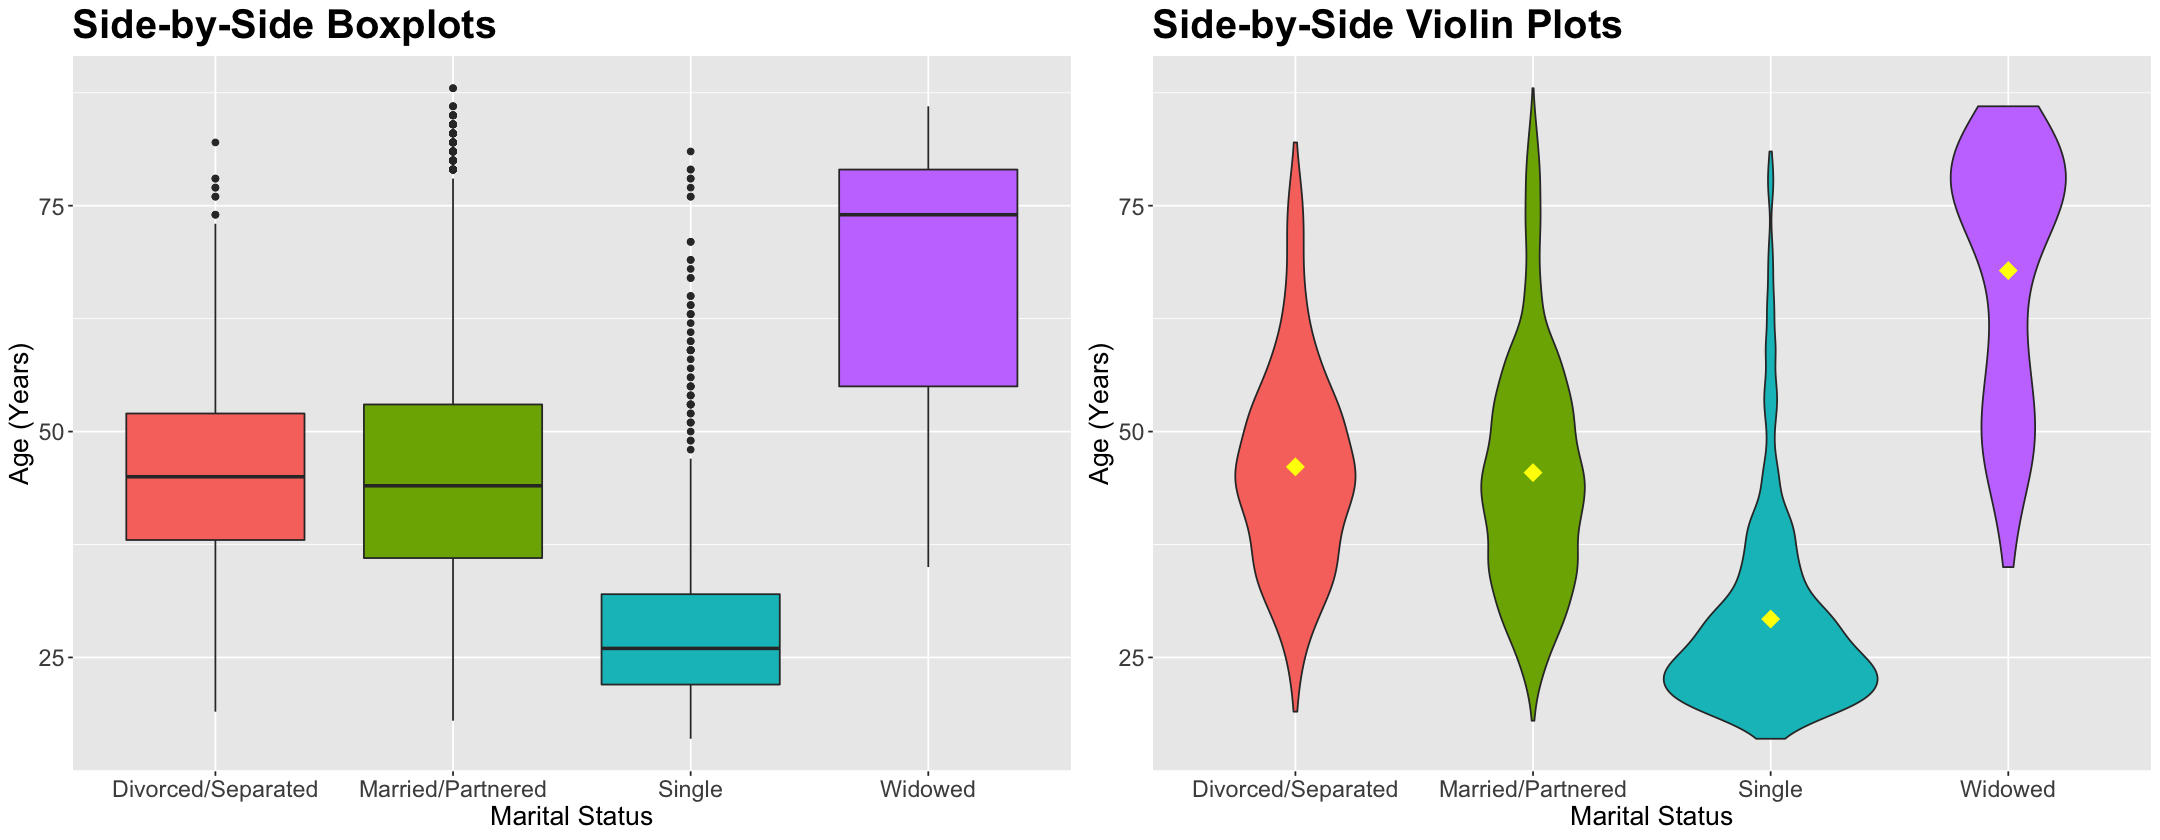

In [5]:
options(repr.plot.height = 7, repr.plot.width = 18)

plot_grid(marital.side.boxplots, marital.side.violin, nrow = 1)

### In-Class Activity
 
What can we *descriptively* see from the plots?

> The `Widowed` people are older, as expected. 

> A large number of `Divorced/Separated` people are around 45 years. 

> Many people are `Married/Partnered` in the late 20s and early 30s. But just a few people are `Married/Partnered` in their mid-60s.

> Very few people are `Single` after the 40s.

Let us set the multinomial logistic regression model with `mstatus` as a response subject to `age` as a continuous regressor, but first we have to check what the baseline category is in `mstatus`.

In [6]:
levels(marital.nz$mstatus)

[1] "Divorced/Separated" "Married/Partnered"  "Single"            
[4] "Widowed"

> The `vglm()` function uses the first level **from right to left** as the baseline category. We would like to use `Single` as the baseline:

In [7]:
marital.nz$mstatus <- fct_relevel(
  marital.nz$mstatus,
  c("Widowed", "Divorced/Separated", "Married/Partnered", "Single")
)
levels(marital.nz$mstatus)

[1] "Widowed"            "Divorced/Separated" "Married/Partnered" 
[4] "Single"

Let us set up the multinomial logistic regression model in this case. For the $i$th observation with the regressor $X_{i, \texttt{age}}$, we have a system of $3$ link functions as follows:

\begin{gather*}
\eta_i^{(\texttt{Widowed},\texttt{Single})} = \log\left[\frac{\Pr(Y_i = \texttt{Widowed} \mid X_{i, \texttt{age}})}{\Pr(Y_i = \texttt{Single} \mid X_{i, \texttt{age}})}\right] = \beta_0^{(\texttt{Widowed},\texttt{Single})} + \beta_1^{(\texttt{Widowed},\texttt{Single})} X_{i, \texttt{age}} \\
\eta_i^{(\texttt{Divorced},\texttt{Single})} = \log\left[\frac{\Pr(Y_i = \texttt{Divorced} \mid X_{i, \texttt{age}})}{\Pr(Y_i = \texttt{Single} \mid X_{i, \texttt{age}})}\right] = \beta_0^{(\texttt{Divorced},\texttt{Single})} + \beta_1^{(\texttt{Divorced},\texttt{Single})} X_{i, \texttt{age}} \\
\eta_i^{(\texttt{Married},\texttt{Single})} = \log\left[\frac{\Pr(Y_i = \texttt{Married} \mid X_{i, \texttt{age}})}{\Pr(Y_i = \texttt{Single} \mid X_{i, \texttt{age}})}\right] = \beta_0^{(\texttt{Married},\texttt{Single})} + \beta_1^{(\texttt{Married},\texttt{Single})} X_{i, \texttt{age}}.
\end{gather*}

Each link function has its intercept and slope.

The probabilities of $Y_i$ belonging to categories `Single`, `Widowed`, `Divorced/Separated`, and `Married/Partnered` are:

\begin{gather*}
\pi_{i,\texttt{Single}} = \Pr(Y_i = \texttt{Single} \mid X_{i,\texttt{age}}) = \frac{1}{1 + \eta_i^{(\texttt{Widowed},\texttt{Single})} + \eta_i^{(\texttt{Divorced},\texttt{Single})} + \eta_i^{(\texttt{Married},\texttt{Single})}} \\
\pi_{i,\texttt{Widowed}} = \Pr(Y_i = \texttt{Widowed} \mid X_{i,\texttt{age}}) = \frac{\exp \big( \eta_i^{(\texttt{Widowed},\texttt{Single})} \big)}{1 + \eta_i^{(\texttt{Widowed},\texttt{Single})} + \eta_i^{(\texttt{Divorced},\texttt{Single})} + \eta_i^{(\texttt{Married},\texttt{Single})}} \\
\pi_{i,\texttt{Divorced}} = \Pr(Y_i = \texttt{Divorced} \mid X_{i,\texttt{age}}) = \frac{\exp \big( \eta_i^{(\texttt{Divorced},\texttt{Single})} \big)}{1 + \eta_i^{(\texttt{Widowed},\texttt{Single})} + \eta_i^{(\texttt{Divorced},\texttt{Single})} + \eta_i^{(\texttt{Married},\texttt{Single})}} \\
\pi_{i,\texttt{Married}} = \Pr(Y_i = \texttt{Married} \mid X_{i,\texttt{age}}) = \frac{\exp \big( \eta_i^{(\texttt{Married},\texttt{Single})} \big)}{1 + \eta_i^{(\texttt{Widowed},\texttt{Single})} + \eta_i^{(\texttt{Divorced},\texttt{Single})} + \eta_i^{(\texttt{Married},\texttt{Single})}}.
\end{gather*}

### In-Class Activity

**TRUE or FALSE?**: Now that we removed the restriction of only one link function, we also removed the distributional assumption for $Y_i$. Hence, our model has no distribution assumption.

> *FALSE*. We have not removed any distributional assumption. We just replaced the distributional assumption from binomial to multinomial.

**TRUE or FALSE?**: The model is now non-parametric.

> *FALSE*. We are specifying the model function for each one of the logit functions.

### 3.3. Estimation

All parameters in the multinomial logistic regression model are also unknown. To fit the model with the package `VGAM`, we use the function `vglm()` and its argument `family = multinomial` (required to specify the response's multinomial nature), which obtains the corresponding estimates. The estimates are obtained through maximum likelihood, where we assume a multinomial joint probability mass function of the $n$ responses $Y_i$.

In [8]:
multinomial_model <- vglm(mstatus ~ age, family = multinomial, data = marital.nz)

### 3.4. Inference

We can determine whether a regressor is statistically associated with the logarithm of the odds through hypothesis testing for the parameters $\beta_j^{(i, k)}$ *by link function*. We also use the Wald statistic $z_j^{(i, k)}$:

\begin{equation*}
z_j^{(i, k)} = \frac{\hat{\beta}_j^{(i, k)}}{\mbox{se}\big(\hat{\beta}_j^{(i, k)}\big)}
\end{equation*}

to test the hypotheses

\begin{gather*}
H_0: \beta_j^{(i, k)} = 0\\
H_a: \beta_j^{(i, k)} \neq 0.
\end{gather*}

The null hypothesis $H_0$ indicates that the $j$th regressor associated to $\beta_j^{(i, k)}$ does not affect the response variable in the model, and the alternative hypothesis $H_a$ otherwise.

The software provides the corresponding $p$-values for each $\beta_j^{(i, k)}$. The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$. As in the previous regression models, we would set a predetermined significance level $\alpha$ (usually taken to be 0.05 or 0.1) to infer if the $p$-value is small enough. If the $p$-value is smaller than the predetermined level $\alpha$, then you could claim that there is evidence to reject the null hypothesis. Hence, $p$-values that are small enough indicate that the data provides evidence in favour of association between the response variable and the $j$th regressor.

Furthermore, given a specified level of confidence where $\alpha$ is the significance level, we can construct approximate $(1 - \alpha) \times 100\%$ confidence intervals for the corresponding true value of $\beta_j^{(i, k)}$:

\begin{equation*}
\hat{\beta}_j^{(i, k)} \pm z_{\alpha/2}\mbox{se}\big( \hat{\beta}_j^{(i, k)} \big),
\end{equation*}

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the standard normal distribution.

There is no `tidy()` function for a `vglm` model object. The function `tidy.vglm()` (check source [here](https://github.com/tidymodels/broom/issues/135)) can be used.

In [9]:
summary_multinomial_model <- tidy.vglm(multinomial_model,
  conf.int = TRUE, conf.level = 0.95
) %>%
  mutate_if(is.numeric, round, 3)
summary_multinomial_model

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept):1,-13.121,0.514,-25.539,0,-14.128,-12.114
(Intercept):2,-6.368,0.255,-24.954,0,-6.868,-5.868
(Intercept):3,-3.589,0.177,-20.315,0,-3.936,-3.243
age:1,0.252,0.009,28.150,0,0.235,0.270
age:2,0.153,0.007,22.981,0,0.140,0.166
age:3,0.149,0.005,27.489,0,0.139,0.160


Recall that level `4` (i.e., `Single`) is the baseline here:

In [10]:
levels(marital.nz$mstatus)

[1] "Widowed"            "Divorced/Separated" "Married/Partnered" 
[4] "Single"

Hence: 

- `Widowed` is level `1`. 
- `Divorced/Separated` is level `2`. 
- `Married/Partnered` is level `3`.

Finally, from the three link functions in this model, we see that all regression coefficients associated to `age` are statistically significant with $\alpha = 0.05$ (`age:1` for `Widowed` to `Single`, `age:2` for `Divorced/Separated` to `Single`, and `age:3` for `Married/Partnered` to `Single`).

### 3.5. Coefficient Interpretation and Prediction

The interpretation of the multinomial logistic regression coefficients is quite similar to the binomial logistic regression. Let us interpret the association between `age` and `mstatus`.

First, note that in this example, we have four groups: 

- `Widowed`
- `Divorced/Separated`
- `Married/Partnered`
- `Single`.

Therefore, we have three interpretations of `age` with respect to `mstatus` where the baseline is `Single`.

In [11]:
tibble(summary_multinomial_model[4:6, 1:2], exp.estimate = round(exp(summary_multinomial_model[4:6, 2]), 2))

term,estimate,exp.estimate
<chr>,<dbl>,<dbl>
age:1,0.252,1.29
age:2,0.153,1.17
age:3,0.149,1.16


By using the column `exp.estimate`, we interpret the three slopes above as follows:

- $\beta_1^{(\texttt{Widowed},\texttt{Single})}$ (`age:1`): "*for each one year increase in the `age`, the odds that the respondent is `Widowed` rather than `Single` increase by 29%*."
- $\beta_1^{(\texttt{Divorced},\texttt{Single})}$ (`age:2`): "*for each one year increase in the `age`, the odds that the respondent is `Divorced/Separated` rather than `Single` increase by 17%*."
- $\beta_1^{(\texttt{Married},\texttt{Single})}$ (`age:3`): "*for each one year increase in the `age`, the odds that the respondent is `Married/Partnered` rather than `Single` increase by 16%*."

### In-Class Activity

Now, using the object `multinomial_model` with `predict()`, calculate the predicted odds of someone being `Married/Partnered` versus `Single` at the `age` of 20. Interpret the result *in plain words*.

In [12]:
pred_odds_age_20 <- round(exp(predict(multinomial_model, tibble(age = 20), type = "link")), 2)
pred_odds_age_20
round(1/ pred_odds_age_20[, 3], 2)

,"log(mu[,1]/mu[,4])","log(mu[,2]/mu[,4])","log(mu[,3]/mu[,4])"
1,0,0.04,0.55


[1] 1.82

Recall that the levels for `Married/Partnered` and `Single` are `3` and `4`, respectively. Then, the predicted odds are 0.55 in the tibble above. We interpret this result as follows: "*someone who is 20 years old is 1.82 ($1/0.55$) times more likely to be `Single` rather than `Married/Partnered`*."

Using the object `multinomial_model` with `predict()`, calculate the predicted odds of someone being `Widowed` versus `Single` at the `age` of 40. Interpret the result in *plain words*.

In [13]:
pred_odds_age_40 <- round(exp(predict(multinomial_model, tibble(age = 40), type = "link")), 2)
pred_odds_age_40
round(1/ pred_odds_age_40[, 1], 2)

,"log(mu[,1]/mu[,4])","log(mu[,2]/mu[,4])","log(mu[,3]/mu[,4])"
1,0.05,0.77,10.79


[1] 20

The levels for `Widowed` and `Single` are `1` and `4`, respectively. Then, the predicted odds are 0.05 in the tibble above. We interpret this result as follows: "*someone who is 40 years old is 20 ($1/0.05$) times more likely to be `Single` rather than `Widowed`*."

### Can We Predict Probabilities For Classification Purposes?

Using the function `predict()` with the object `multinomial_model`, obtain the estimated probabilities for a person who is 80 years old of being `Widowed`, `Divorced/Separated`, `Married/Partnered`, and `Single`. How can we classify this person then?

In [14]:
round(predict(multinomial_model, tibble(age = 80), type = "response"), 2)

,Widowed,Divorced/Separated,Married/Partnered,Single
1,0.2,0.06,0.74,0


We can see that it is most likely to be `Married/Partnered` with a probability of 0.74 at the `age` of 80 with this model. Thus, we could classify the person as `Married/Partnered`.

## 4. Ordinal Logistic Regression

The previous multinomial logistic model **is not suitable for ordinal responses**.

Suppose one does not consider the order in the response levels when necessary. In that case, *we might be at stake of losing valuable information when making inference or predictions*.

Therefore, the ideal approach is a logistic regression that suits **ordinal** responses.

One of this statistical model's main goals is establishing whether there is a significant association between the ordered response and a set of given regressors.

### 4.1. General Modelling Framework of the Ordinal Logistic Regression

Let us suppose that a given *discrete* ordinal response $Y_i$ (for $i = 1, \dots, n$) has categories $1, 2, \dots, k$.

> **Note:** The categories $1, 2, \dots, k$ **implicate an ordinal scale here**, i.e., $1 < 2 < \dots < k$.

There is more than one class of ordinal logistic regression. We will review the *proportional odds* model (*cumulative logit* model).

### Optional Material

Before going into the model's mathematical notation, we have to point out that the ordinal logistic regression will indicate how each one of the regressors affects the logarithm of the odds in the response for the following $k - 1$ situations:

\begin{gather*}
\text{Level } k - 1 \text{ or any lesser degree versus level } k\\
\text{Level } k - 2 \text{ or any lesser degree versus level } k - 1 \text{ or any higher degree}\\
\vdots \\
\text{Level } 2 \text{ or any lesser degree versus level } 3 \text{ or any higher degree}\\
\text{Level } 1 \text{ versus level } 2 \text{ or any higher degree}\\
\end{gather*}

These $k-1$ situations can be translated into cumulative probabilities using the logarithms of the odds on the left-hand side ($k -1$ link functions) subject to the linear combination of the $p$ regressors $X_{i,j}$ (for $j = 1, \dots, p$):

\begin{gather*}
\eta_i^{(k - 1)} = \log\left[\frac{\Pr(Y_i \leq k - 1 \mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i = k \mid X_{i,1}, \ldots, X_{i,p})}\right] = \beta_0^{(k - 1)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_p X_{i, p} \\
\eta_i^{(k - 2)} = \log\left[\frac{\Pr(Y_i \leq k - 2 \mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i > k - 2 \mid X_{i,1}, \ldots, X_{i,p})}\right] = \beta_0^{(k - 2)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_p X_{i, p} \\
\vdots \\
\eta_i^{(2)} = \log\left[\frac{\Pr(Y_i \leq 2 \mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i > 2 \mid X_{i,1}, \ldots, X_{i,p})}\right] = \beta_0^{(2)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_p X_{i, p}
\end{gather*}

\begin{gather*}
\eta_i^{(1)} = \log\left[\frac{\Pr(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i > 1 \mid X_{i,1}, \ldots, X_{i,p})}\right] = \beta_0^{(1)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_p X_{i, p}.
\end{gather*}

Note that the system above has $k - 1$ intercepts but **only $p$ slopes**. In general, the previous $k - 1$ equations can be generalized for levels $j = k - 1, \dots, 1$ as follows :

\begin{gather*}
\eta_i^{(j)} = \log\left[\frac{\Pr(Y_i \leq j \mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i > j \mid X_{i,1}, \ldots, X_{i,p})}\right] = \beta_0^{(j)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_p X_{i, p} \\
\; \; \; \; \; \; \; \; \Rightarrow \; \Pr(Y_i \leq j \mid X_{i,1}, \ldots, X_{i,p}) = \frac{\exp\left(\beta_0^{(j)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_p X_{i, p}\right)}{1 + \exp\left(\beta_0^{(j)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_p X_{i, p}\right)}.
\end{gather*}

The probability that $Y_i$ will fall in the category $j$ can be computed as follows:

\begin{equation*}
\pi_{i,j} = \Pr(Y_i = j \mid X_{i,1}, \ldots, X_{i,p}) = \Pr(Y_i \leq j \mid X_{i,1}, \ldots, X_{i,p}) - \Pr(Y_i \leq j - 1 \mid X_{i,1}, \ldots, X_{i,p}),
\end{equation*}

which leads to
\begin{equation*}
\Pr(Y_i = 1) = \pi_{i,1} \;\;\;\; \Pr(Y_i = 2) = \pi_{i,2} \;\; \dots \;\; \Pr(Y_i = k) = \pi_{i,k},
\end{equation*}

where

\begin{equation*}
\sum_{j = 1}^k \pi_{i,j} = \pi_{i,1} + \pi_{i,2} + \dots + \pi_{i,k} = 1.
\end{equation*}

#### Why Do We Have Proportional Odds in This Model?

If we make some mathematical manipulation on the previous equation system, it turns out that the *proportional odds* come into play as follows:

\begin{gather*}\
\exp{\left(-\beta_0^{(k - 1)}\right)} \frac{\Pr(Y_i \leq k - 1 \mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i = k \mid X_{i,1}, \ldots, X_{i,p})} = \dots = \exp{\left(-\beta_0^{(1)}\right)} \frac{\Pr(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i > 1 \mid X_{i,1}, \ldots, X_{i,p})}.
\end{gather*}

Mathematically, this can be expressed as:

\begin{gather*}
\frac{\Pr(Y_i \leq k - 1 \mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i = k \mid X_{i,1}, \ldots, X_{i,p})} \propto \dots \propto \frac{\Pr(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,p})}{\Pr(Y_i > 1 \mid X_{i,1}, \ldots, X_{i,p})},
\end{gather*}

where the symbol $\propto$ indicates "*proportional to*".

### 4.2. College Juniors Dataset

The data frame `college_data` was obtained from the webpage of the [UCLA Statistical Consulting Group](https://stats.idre.ucla.edu/r/dae/ordinal-logistic-regression/), which is used for ordinal regression. We will also fit an ordinal logistic regression using this dataset, but with a more detailed exploratory analysis and coefficient interpretations.

> The dataset contains the results of a survey applied to 400 college juniors regarding the factors that influence their decision to apply to graduate school.

We have the following variables:

- `decision`: how likely the student will apply to graduate school, a discrete and ordinal response with three increasing categories (`unlikely`, `somewhat likely`, and `very likely`).
- `parent_ed`: whether at least one parent has a graduate degree, a discrete and binary explanatory variable (`Yes` and `No`).
- `GPA`: the student's current GPA, a continuous explanatory variable.

Then, we will fit an ordinal logistic regression model to answer the following questions:

- Is `decision` statistically related to `parent_ed` and `GPA`?
- How can we interpret these statistical relationships (*if there are any*)?

We load the data frame `college_data`.

In [15]:
college_data <- suppressMessages(read_csv("../datasets/college_data.csv"))
college_data$decision <- as.ordered(college_data$decision)
college_data$decision <- fct_relevel(
  college_data$decision,
  c("unlikely", "somewhat likely", "very likely")
)
levels(college_data$decision)

head(college_data)

[1] "unlikely"        "somewhat likely" "very likely"

decision,parent_ed,GPA
<ord>,<chr>,<dbl>
very likely,No,3.26
somewhat likely,Yes,3.21
unlikely,Yes,3.94
somewhat likely,No,2.81
somewhat likely,No,2.53
unlikely,No,2.59


> **Note:** The function `as.ordered()` creates an ordered factor. 

Let us plot the data first.

Note that `decision` is a discrete ordinal response, so again we have to be careful about the class of plots we are using regarding exploratory data analysis.

To explore visually the relationship between `decision` and `GPA` , we will use the following side-by-side plots:

- Boxplots.
- Violin plots.

In [16]:
college_data.side.boxplots <- college_data %>%
  ggplot(aes(decision, GPA)) +
  geom_boxplot(aes(fill = decision)) +
  labs(y = "GPA", x = "Decision to Apply to Graduate School") +
  ggtitle("Side-by-Side Boxplots") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16),
    legend.position = "none"
  )

college_data.side.violin <- college_data %>%
  ggplot(aes(decision, GPA)) +
  geom_violin(aes(fill = decision)) +
  labs(y = "GPA", x = "Decision to Apply to Graduate School") +
  ggtitle("Side-by-Side Violin Plots") +
  stat_summary(
    fun = mean, colour = "red", geom = "point",
    shape = 18, size = 5
  ) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16),
    legend.position = "none"
  )

The code above creates side-by-side boxplots and violin plots, where `GPA` is on the $y$-axis, and all categories of `decision` are on the $x$-axis. The side-by-side violin plots show the mean of `GPA` by `decision` category in red points.

Now, how can we visually explore the relationship between `decision` and `parent_ed`?

In the case of two categorical explanatory variables, we can use stacked bar charts. Each bar will show the percentages (depicted on the $y$-axis) of college students falling on each ordered category of `decision` with the categories found in `parent_ed` on the $x$-axis. This class of bars will allow us to compare both levels of `parent_ed` in terms of the categories of `decision`.

In [17]:
college_data.prop.summary <- as.data.frame(xtabs(
  ~ parent_ed +
    decision,
  college_data
) / rowSums(xtabs(
  ~ parent_ed + decision,
  college_data
)), responseName = "prop")

college_data.prop.summary

parent_ed,decision,prop
<fct>,<fct>,<dbl>
No,unlikely,0.59347181
Yes,unlikely,0.31746032
No,somewhat likely,0.32640950
Yes,somewhat likely,0.47619048
No,very likely,0.08011869
Yes,very likely,0.20634921


First of all, we need to do some data wrangling. The code above obtains the conditioned proportions for each level of `decision` conditioned on the categories of `parent_ed`. If we add up all proportions corresponding to `No` or `Yes`, we will obtain 1.

In [18]:
college_data.stacked.bars <- ggplot(college_data.prop.summary, aes(x = parent_ed, 
                                                                   y = prop, fill = decision)) +
  geom_bar(stat = "identity", width = 0.7, colour = "black", lwd = 0.1) +
  geom_text(aes(label = ifelse(prop >= 0.05, paste0(sprintf("%.0f", prop*100),"%"),"")),
            position = position_stack(vjust = 0.5), colour = "firebrick3", fontface = "bold", size = 5) +
  scale_y_continuous(labels = percent_format()) +
  labs(y = "Percent", x = "Parent Education Status", fill = "") +
  ggtitle("Stacked Bar Charts")  +
  theme(plot.title = element_text(size = 24, face = "bold"),
        axis.text.x = element_text(size = 14, angle = 0),
        axis.text.y = element_text(size = 14, angle = 0),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14, margin = margin(r = 1, unit = "cm")), 
        legend.title = element_text(size = 14, face = "bold")) +
  guides(fill = guide_legend(title = "Decision")) + scale_fill_brewer(palette = "Blues")

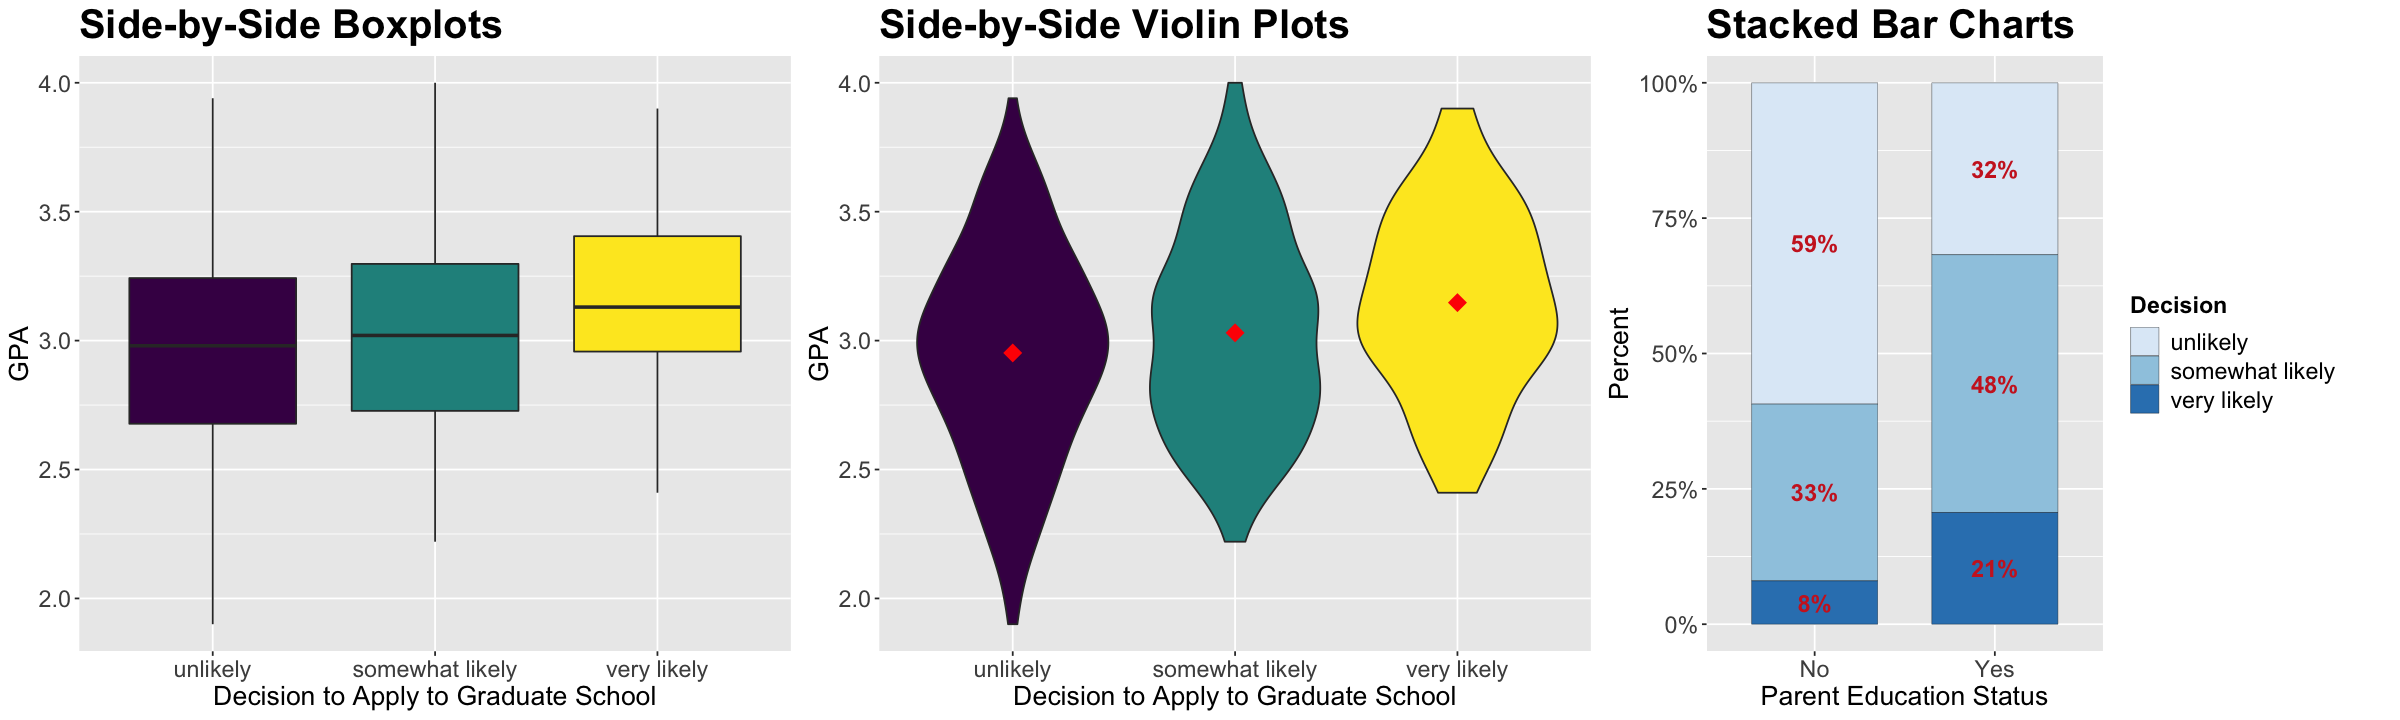

In [19]:
options(repr.plot.height = 6, repr.plot.width = 20)

plot_grid(college_data.side.boxplots, college_data.side.violin, college_data.stacked.bars, nrow = 1)

### In-Class Activity
 
What can we *descriptively* see from the plots?

> Those students with higher `GPA` tend to be `very likely` to apply to graduate school.

> Interestingly, those students with at least one parent with a graduate degree tend to be `very likely` to apply to graduate school.

Let us set up the ordinal logistical regression model in this case. For the $i$th observation with the continuous $X_{i, \texttt{GPA}}$ and the dummy variable $X_{i, \texttt{parent_ed}}$, the model will indicate how each one of the regressors affects the logarithm of the odds in `decision` for the following $2$ situations:

\begin{gather*}
\text{Level } \texttt{somewhat likely}  \text{ or any lesser degree versus level } \texttt{very likely} \\
\text{Level } \texttt{unlikely} \text{ versus level } \texttt{somewhat likely} \text{ or any higher degree}
\end{gather*}

We have the following system of $2$ equations:

\begin{align*}
\eta_i^{(\texttt{somewhat likely})} &= \log\left[\frac{\Pr(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}\right] \\ &= \beta_0^{(\texttt{somewhat likely})} - \beta_1 X_{i, \texttt{GPA}} - \beta_2 X_{i, \texttt{parent_ed}}
\end{align*}

\begin{align*}
\eta_i^{(\texttt{unlikely})} &= \log\left[\frac{\Pr(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}\right] \\ &= \beta_0^{(\texttt{unlikely})} - \beta_1 X_{i, \texttt{GPA}} - \beta_2 X_{i, \texttt{parent_ed}}.
\end{align*}

The system has $2$ intercepts but **only $2$ slopes**. Check the signs of the **common** $\beta_1$ and $\beta_2$, which are minuses. This is a very common parameterization of the *proportional odds* model (which is used in `R`).

To make coefficient intepretation easier, we could re-expresss the equations of $\eta_i^{(\texttt{somewhat likely})}$  and $\eta_i^{(\texttt{unlikely})}$ as follows:

\begin{equation*}
\frac{\Pr(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})} = \exp\big(-\beta_0^{(\texttt{somewhat likely})}\big) \exp\big(\beta_1 X_{i, \texttt{GPA}}\big) \exp\big(\beta_2 X_{i, \texttt{parent_ed}}\big)
\end{equation*}

\begin{equation*}
\frac{\Pr(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})} = \exp\big(-\beta_0^{(\texttt{unlikely})}\big) \exp\big(\beta_1 X_{i, \texttt{GPA}}\big) \exp\big(\beta_2 X_{i, \texttt{parent_ed}}\big).
\end{equation*}

Both regression coefficients ($\beta_1$ and $\beta_2$) have a multiplicative effect on the odds on the left-hand side. Moreover, given the proportional odds assumptions, the regressor effects are the same for both odds.

Moreover, let us show *what the proportional odds stand for*:

\begin{align*}
\exp\big(\beta_0^{(\texttt{somewhat likely})}\big) \frac{\Pr(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})} &= \exp\big(\beta_1 X_{i, \texttt{GPA}}\big) \exp\big(\beta_2 X_{i, \texttt{parent_ed}}\big) \\
&= \exp\big(\beta_0^{(\texttt{unlikely})}\big) \frac{\Pr(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}
\end{align*}

\begin{align*}
\Rightarrow \frac{\exp\big(\beta_0^{(\texttt{somewhat likely})}\big)}{\exp\big(\beta_0^{(\texttt{unlikely})}\big)} \times
\frac{\Pr(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})} = \frac{\Pr(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}
\end{align*}

\begin{align*}
\frac{\Pr(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})} \propto \frac{\Pr(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})},
\end{align*}

where the symbol $\propto$ indicates "*proportional to*".

### 4.3. Estimation

All parameters in the ordinal logistic regression model are also unknown. The estimates are obtained through maximum likelihood, where we assume a multinomial joint probability mass function of the $n$ responses $Y_i$. To fit the model with the package `MASS`, we use the function `polr()`, which obtains the corresponding estimates. The argument `Hess = TRUE` is required to compute the Hessian matrix, which is used to obtain the standard errors of the estimates. 

In [20]:
ordinal_model <- polr(decision ~ parent_ed + GPA,
  data = college_data, Hess = TRUE
)

### 4.4. Inference

We can determine whether a regressor is statistically associated with the logarithm of the odds through hypothesis testing for the parameters $\beta_j$. We also use the Wald statistic $z_j$:

\begin{equation*}
z_j = \frac{\hat{\beta}_j}{\mbox{se}(\hat{\beta}_j)}
\end{equation*}

to test the hypotheses

\begin{gather*}
H_0: \beta_j = 0\\
H_a: \beta_j \neq 0.
\end{gather*}

The null hypothesis $H_0$ indicates that the $j$th regressor associated to $\beta_j$ does not affect the response variable in the model, and the alternative hypothesis $H_a$ otherwise.

The software provides the corresponding $p$-values for each $\beta_j$. The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$. As in the previous regression models, we would set a predetermined significance level $\alpha$ (usually taken to be 0.05 or 0.1) to infer if the $p$-value is small enough. If the $p$-value is smaller than the predetermined level $\alpha$, then you could claim that there is evidence to reject the null hypothesis. Hence, $p$-values that are small enough indicate that the data provides evidence in favour of association between the response variable and the $j$th regressor.

Furthermore, given a specified level of confidence where $\alpha$ is the significance level, we can construct approximate $(1 - \alpha) \times 100\%$ confidence intervals for the corresponding true value of $\beta_j$:

\begin{equation*}
\hat{\beta}_j \pm z_{\alpha/2}\mbox{se}(\hat{\beta}_j),
\end{equation*}

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the standard normal distribution.

The function `polr()` does not provide $p$-values, but we can compute them as follows:

In [21]:
summary_ordinal_model <- cbind(tidy(ordinal_model),
  p.value = pnorm(abs(tidy(ordinal_model)$statistic),
    lower.tail = FALSE
  ) * 2
) %>%
  mutate_if(is.numeric, round, 2)
summary_ordinal_model

term,estimate,std.error,statistic,coef.type,p.value
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
parent_edYes,1.05,0.27,3.94,coefficient,0.00
GPA,0.60,0.25,2.38,coefficient,0.02
unlikely|somewhat likely,2.18,0.77,2.84,scale,0.00
somewhat likely|very likely,4.27,0.79,5.39,scale,0.00


The terms `unlikely|somewhat likely` and `somewhat likely|very likely` refer to the estimated intercepts $\hat{\beta}_0^{(\texttt{unlikely})}$ and $\hat{\beta}_0^{(\texttt{somewhat likely})}$, respectively (note the hat notation).

Finally, we see that the coefficients associated with `GPA` and `parent_ed` are statistically significant with $\alpha = 0.05$.

The function `confint()` can provide the 95% confidence intervals for the estimates contained in `tidy()`.

In [22]:
round(confint(ordinal_model), 2)

Waiting for profiling to be done...



,2.5 %,97.5 %
parent_edYes,0.53,1.57
GPA,0.11,1.11


### 4.5. Coefficient Interpretation and Prediction

The interpretation of the ordinal logistic regression coefficients will change since we are modelling cumulative probabilities. Let us interpret the association of `decision` with `GPA` and `parent_ed`.

In [23]:
tibble(summary_ordinal_model[1:2, 1:2], exp.estimate = round(exp(summary_ordinal_model[1:2, 2]), 2))

term,estimate,exp.estimate
<chr>,<dbl>,<dbl>
parent_edYes,1.05,2.86
GPA,0.60,1.82


By using the column `exp.estimate`, **along with the model equations on the original scale of the odds**, we interpret the two slopes above **by each odds** as follows:

- For the odds $\frac{\Pr(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}$:

    - $\beta_1$: "*for each one-unit increase in the `GPA`, the odds that the student is `very likely`  versus `somewhat likely` or `unlikely` to apply to graduate school increase by 1.82 times (while holding `parent_ed` constant)*."
    - $\beta_2$: "*for those respondents whose parents attended to graduate school, the odds that the student is `very likely`  versus `somewhat likely` or `unlikely` to apply to graduate school increase by 2.86 times (when compared to those respondents whose parents did not attend to graduate school and holding `GPA` constant)*."

- For the odds $\frac{\Pr(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}$:

    - $\beta_1$: "*for each one-unit increase in the `GPA`, the odds that the student is `very likely` or `somewhat likely` versus `unlikely` to apply to graduate school increase by 1.82 times (while holding `parent_ed` constant)*."
    - $\beta_2$: "*for those respondents whose parents attended to graduate school, the odds that the student is `very likely`  or `somewhat likely` versus `unlikely` to apply to graduate school increase by 2.86 times (when compared to those respondents whose parents did not attend to graduate school and holding `GPA` constant)*."

### Can We Predict Probabilities For Classification Purposes? What about Cumulative Odds?

Using the function `predict()` with the object `ordinal_model`, obtain the estimated probabilities to apply to graduate school (associated to `unlikely`, `somewhat likely`, and `very likely`) for a student with a `GPA` of 3.5 whose parents attended to graduate school.

In [28]:
round(predict(ordinal_model, tibble(GPA = 3.5, parent_ed = "Yes"), type = "probs"), 2)

unlikely somewhat likely     very likely 
           0.27            0.48            0.25

We can see that it is `somewhat likely` to apply to graduate school with a probability of 0.48. Thus, we could classify the student in this ordinal category.

Unfortunately, `predict()` with `polr()` does not provide a quick way to compute this model's corresponding predicted cumulative odds for a new observation. Nonetheless, we could use `vglm()` again while keeping in mind that **this function labels the response categories as numbers**. Let us check this for `decision` with `levels()`.

In [54]:
levels(college_data$decision)

[1] "unlikely"        "somewhat likely" "very likely"

Hence, `unlikely` is `1`, `somewhat likely` is `2`, and `very likely` is `3`. Now, let us use `vglm()` with `propodds` to fit the same model (named `ordinal_model_vglm`) as follows:

In [55]:
ordinal_model_vglm <- vglm(decision ~ parent_ed + GPA, propodds,
  data = college_data)

We will double-check whether `ordinal_model_vglm` provides the same classification probabilities via `predict()`. Note that the function parameterization changes to `type = "response"`.

In [56]:
round(predict(ordinal_model_vglm, tibble(GPA = 3.5, parent_ed = "Yes"), type = "response"), 2)

,unlikely,somewhat likely,very likely
1,0.27,0.48,0.25


Yes, we get identical results using `vglm()`. Now, let us use `predict()` with `ordinal_model_vglm` to obtain the predicted cumulative odds for a student with a `GPA` of 3.5 whose parents attended to graduate school (via argument `type = "link"` in `predict()`).

In [57]:
round(predict(ordinal_model_vglm, tibble(GPA = 3.5, parent_ed = "Yes"), type = "link"), 2)

,logitlink(P[Y>=2]),logitlink(P[Y>=3])
1,0.98,-1.11


Then, let us take these predictions to the odds' original scale via `exp()`.

In [59]:
round(exp(predict(ordinal_model_vglm, tibble(GPA = 3.5, parent_ed = "Yes"), type = "link")), 2)

,logitlink(P[Y>=2]),logitlink(P[Y>=3])
1,2.68,0.33


Again, we see the numeric labels (a drawback of using `vglm()`). We interpret these predictions as follows:

- $\frac{\Pr(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}$, i.e., `P[Y>=3]` (label `3`, `very likely`): "*a student, with a `GPA` of 3.5 whose parents attended to graduate school, is 3.03 ($1 / 0.33$) times `somewhat likely` or `unlikely` versus `very likely` to apply to graduate school*." This prediction goes in line with the predicted probabilities above, given that `somewhat likely` has a probability of 0.48 and `unlikely` a probability of 0.27.

- $\frac{\Pr(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{\Pr(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}$, i.e., `P[Y>=2]` (label `2`, ` somewhat likely`): "*a student, with a `GPA` of 3.5 whose parents attended to graduate school, is 2.68 times `very likely` or `somewhat likely` versus `unlikely` to apply to graduate school*." This prediction goes in line with the predicted probabilities above, given that `somewhat likely` has a probability of 0.48 and ` very likely` a probability of 0.25.